# Run 5 : MLP (tensorflow)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Word2Vec
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Tensorflow
import tensorflow as tf

### Chargement des données d'apprentissage et de test

In [2]:
df_train = pd.read_csv("../data/train.csv", sep=',', encoding='utf-8')
df_validation = pd.read_csv("../data/validation.csv", sep=',', encoding='utf-8')
df_test = pd.read_csv("../data/test.csv", sep=',', encoding='utf-8')

### Vectorisation des données avec  TF-IDF et encodage des labels

In [3]:
stop_words = set(stopwords.words('french'))

df_train['vecteur'] = df_train['titre'] + " " + df_train['recette']
df_validation['vecteur'] = df_validation['titre'] + " " + df_validation['recette']
df_test['vecteur'] = df_test['titre'] + " " + df_test['recette']

# tokenisation 
def tokenize_text(text):
    tokens = word_tokenize(text, language="french")
    mal_segmentes = [t for t in tokens if "'" in t]
    tokens = [word.lower() for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

df_train['tokenize_text'] = df_train['vecteur'].apply(tokenize_text)
df_validation['tokenize_text'] = df_validation['vecteur'].apply(tokenize_text)
df_test['tokenize_text'] = df_test['vecteur'].apply(tokenize_text)

# modèle Word2Vec 
model = Word2Vec(sentences=df_train['tokenize_text'], vector_size=100, window=5, min_count=1, workers=4)

# vecteur pour une phrase
def get_vector(words, model):
    words = [word for word in words if word in model.wv]
    return np.mean(model.wv[words], axis=0)

# transformation en vecteur 
x_train = np.array(df_train['tokenize_text'].apply(lambda words: get_vector(words, model)).tolist())
x_validation = np.array(df_validation['tokenize_text'].apply(lambda words: get_vector(words, model)).tolist())
x_test = np.array(df_test['tokenize_text'].apply(lambda words: get_vector(words, model)).tolist())

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train["type"])
y_validation = label_encoder.transform(df_validation["type"])
y_test = label_encoder.transform(df_test["type"])

### Affichage des tailles des tensors pour adapter la taille du modèles

In [4]:
print(x_train.shape, y_train.shape)
print(x_validation.shape, y_validation.shape)
print(x_test.shape, y_test.shape)

(11225, 100) (11225,)
(1248, 100) (1248,)
(1388, 100) (1388,)


### Modèle

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(100,)),  
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

In [22]:
with tf.device('/GPU:0'):
    print("------Train data------")
    train = model.fit(x_train, y_train, epochs=25, batch_size=32) 
    #on a le pic sur la courbe validation a l'epoch 25 donc il faut pas aller au dessus pour ne pas faire du sur entraînement
    print("\n------Train 2 data------") 
    test = model.fit(x_validation, y_validation, epochs=25, batch_size=32)

------Train data------
Epoch 1/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 817us/step - accuracy: 0.7760 - loss: 0.5354
Epoch 2/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - accuracy: 0.8131 - loss: 0.4109
Epoch 3/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - accuracy: 0.8284 - loss: 0.3827
Epoch 4/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - accuracy: 0.8345 - loss: 0.3749
Epoch 5/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.8401 - loss: 0.3635
Epoch 6/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - accuracy: 0.8434 - loss: 0.3483
Epoch 7/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.8412 - loss: 0.3548
Epoch 8/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.8439 - loss: 0.3590
Epoch 9/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.8420 - loss: 0.3491
Epoch 10/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.8486 - loss: 0.3339
Epoch 11/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.8474 - loss: 0.3412
Epoch 1

#### Graphique des pertes

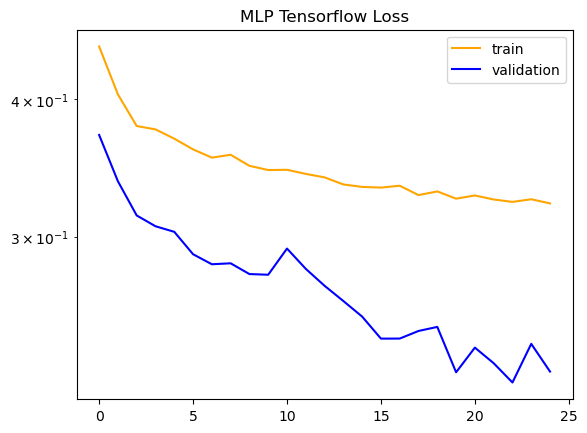

In [23]:
plt.plot(train.history['loss'], color='orange')
plt.plot(test.history['loss'], color='blue')
plt.legend(['train', 'validation'])
plt.yscale('log')
plt.title("MLP Tensorflow Loss")
plt.show()

### Prédiction

In [24]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step


### Résultats

In [25]:
score = accuracy_score(y_test, y_pred_classes)
print("Accuracy:", score, "\n")
print(classification_report(y_test, y_pred_classes), "\n")

Accuracy: 0.8148414985590778 

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       407
           1       0.61      0.70      0.65       337
           2       0.84      0.78      0.81       644

    accuracy                           0.81      1388
   macro avg       0.81      0.82      0.81      1388
weighted avg       0.82      0.81      0.82      1388
 



<Axes: >

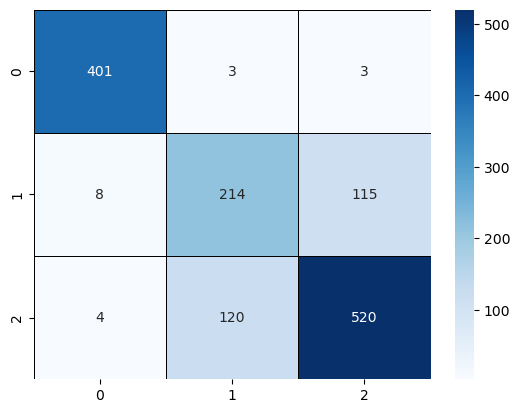

In [10]:
import seaborn as sns 
matrix = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="black")